# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

[Шаг1](#шаг_1)

1. Импортируем библиотеки  
2. Прочитаем данные и изучим состав датафрейма  
3. Какие аномалии бросились в глаза


[Шаг2](#шаг_2)

1.Проверяем данные на нулевые значения и пропуски  
2.Удаляем ненужное  
3.Заполняем пропуски

[Шаг3](#шаг_3)

1.Добавляем столбец с ценой за квадратный метр  
2.Добавляем столбец с групировкой по этажам: первый, последний и другое   
3.Найдем соотношение жилой и общей площади, а также отношение площади кухни к общей  
4.Изучаем данные о площади, цене, числу комнат, высоте потолков и строим гистограммы к каждому параметру

[Шаг4](#шаг_4)

1.Изучаем зависимость стоимости квартир от площади, количества комнат, этажа  
2.Изучаем зависимость цены квартир от дня недели, месяца и года публикации объявления  
3.Находим 10 населенных пунктов с самым большим количеством объявлений и анализируем данные  
4.Изучаем и анализируем данные по Санкт-Петербургу  
5.Оцениваем разницу между средней стоимостью квартир в центре и в отдалении отцентра

[Шаг5](#шаг_5)

Общий вывод

## *Описание состава столбцов:*
airports_nearest — расстояние до ближайшего аэропорта в метрах (м)  
balcony — число балконов  
ceiling_height — высота потолков (м)  
cityCenters_nearest — расстояние до центра города (м)  
days_exposition — сколько дней было размещено объявление (от публикации до снятия)  
first_day_exposition — дата публикации  
floor — этаж  
floors_total — всего этажей в доме  
is_apartment — апартаменты (булев тип)  
kitchen_area — площадь кухни (м²)  
last_price — цена на момент снятия с публикации  
living_area — жилая площадь (м²)  
locality_name — название населённого пункта  
open_plan — свободная планировка (булев тип)  
parks_around3000 — число парков в радиусе 3 км  
parks_nearest — расстояние до ближайшего парка (м)  
ponds_around3000 — число водоёмов в радиусе 3 км  
ponds_nearest — расстояние до ближайшего водоёма (м)  
rooms — число комнат  
studio — квартира-студия (булев тип)  
total_area — площадь квартиры в квадратных метрах (м²)  
total_images — число фотографий квартиры в объявлении  

### Шаг 1. Откройте файл с данными и изучите общую информацию. <a id="шаг_1"></a>

In [399]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
from pymystem3 import Mystem
from collections import Counter

Импортируем табличку с даными, посмотрим выборку по случайным стокам и общую информацию

In [400]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') 
pd.options.display.max_columns = None
data.sample(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22266,8,7400000.0,49.0,2016-02-26T00:00:00,2,NaN,23.0,33.0,10,NaN,False,False,NaN,2.0,Санкт-Петербург,35555.0,15561.0,0.0,NaN,1.0,1180.0,189.0
18391,15,32238780.0,197.9,2018-08-21T00:00:00,3,3.0,20.0,NaN,19,NaN,False,False,11.78,4.0,Санкт-Петербург,18810.0,4404.0,0.0,NaN,0.0,NaN,91.0
5696,9,3480000.0,43.9,2018-01-20T00:00:00,2,NaN,5.0,27.9,4,NaN,False,False,5.00,NaN,Санкт-Петербург,7056.0,17233.0,1.0,658.0,0.0,NaN,3.0
21809,20,10600000.0,77.0,2019-04-16T00:00:00,2,NaN,35.0,39.0,11,NaN,False,False,14.00,2.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,NaN
7747,6,1600000.0,58.0,2017-04-06T00:00:00,3,NaN,5.0,40.0,1,NaN,False,False,6.30,0.0,Ивангород,NaN,NaN,NaN,NaN,NaN,NaN,45.0
915,10,2200000.0,42.0,2018-05-14T00:00:00,2,NaN,3.0,27.0,3,False,False,False,NaN,NaN,деревня Кипень,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22430,6,520000.0,30.0,2017-09-15T00:00:00,1,NaN,2.0,18.0,1,NaN,False,False,5.50,NaN,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,163.0
9207,11,3400000.0,39.3,2018-06-06T00:00:00,1,2.7,18.0,15.4,9,NaN,False,False,11.80,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,284.0
22636,19,7950000.0,42.0,2017-09-26T00:00:00,1,3.0,23.0,18.0,11,NaN,False,False,11.00,2.0,Санкт-Петербург,26402.0,5249.0,0.0,NaN,2.0,444.0,225.0
7668,20,4150000.0,45.0,2017-11-23T00:00:00,1,2.8,16.0,20.0,10,NaN,False,False,12.00,2.0,Санкт-Петербург,15331.0,14127.0,0.0,NaN,0.0,NaN,30.0


In [401]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
total_images,23699.0,9.858475e+00,5.682529e+00,0.0,6.00,9.00,14.0,50.0
last_price,23699.0,6.541549e+06,1.088701e+07,12190.0,3400000.00,4650000.00,6800000.0,763000000.0
total_area,23699.0,6.034865e+01,3.565408e+01,12.0,40.00,52.00,69.9,900.0
rooms,23699.0,2.070636e+00,1.078405e+00,0.0,1.00,2.00,3.0,19.0
ceiling_height,14504.0,2.771499e+00,1.261056e+00,1.0,2.52,2.65,2.8,100.0
floors_total,23613.0,1.067382e+01,6.597173e+00,1.0,5.00,9.00,16.0,60.0
living_area,21796.0,3.445785e+01,2.203045e+01,2.0,18.60,30.00,42.3,409.7
floor,23699.0,5.892358e+00,4.885249e+00,1.0,2.00,4.00,8.0,33.0
kitchen_area,21421.0,1.056981e+01,5.905438e+00,1.3,7.00,9.10,12.0,112.0
balcony,12180.0,1.150082e+00,1.071300e+00,0.0,0.00,1.00,2.0,5.0


In [402]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

Посмотрим на количество пропущенных значений

In [403]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

In [404]:
#не очень понятно, много это или нормально. Посомтрим в процентах.
data.isnull().sum()/data.shape[0]*100

total_images             0.000000
last_price               0.000000
total_area               0.000000
first_day_exposition     0.000000
rooms                    0.000000
ceiling_height          38.799105
floors_total             0.362885
living_area              8.029875
floor                    0.000000
is_apartment            88.290645
studio                   0.000000
open_plan                0.000000
kitchen_area             9.612220
balcony                 48.605426
locality_name            0.206760
airports_nearest        23.384953
cityCenters_nearest     23.287902
parks_around3000        23.283683
parks_nearest           65.909954
ponds_around3000        23.283683
ponds_nearest           61.559559
days_exposition         13.422507
dtype: float64

Отдельно выборка городов где продают квартиры

In [405]:
data['locality_name'].describe(include = ['all'])

count               23650
unique                364
top       Санкт-Петербург
freq                15721
Name: locality_name, dtype: object

### Вывод

-Очень много данных в которых стоит усомниться и поразбираться.  
-Стало прямо очень любопытно что за однушка за 24 миллиона площадью 38 квадратов во Всеволжске - сколько еще таких странных квартир? Каким сопособом сформирована такая цена?  
-Намерянно не стала искать дубликаты, т.к. лучше сделать это после замены пропусков и очистки данных.  
-Есть пропущенные данные в важных столбцах, например если нет данных о городе (столбец locality_name) где  находится квартира, как такое продавать?  
-364 названия населенных пунктов, многовато. Скорее всего дело в разнице написания городов, регистра и пр. Надо проверить и попытаться сократить список.   
-Апартаменты - это особый вид недвижимости: нeжилыe пoмeщeния, в кoтopыx coздaны ycлoвия для пpoживaния. Их цена существенно отличается от обычных жилых помещений т.к. есть ряд ограничений связанных с операциями с апартаментами.  Считаю разумным их отфильровать и отбросить.  
-Преобразовать тип данных в столбцах с числом балконов, этажей и дней публикации с float64 на int64  
-100 метровый потолок тоже заслуживает внимания - изучим и по возможности, исправим, аномалии.  



### Шаг 2. Предобработка данных<a id="шаг_2"></a>

Сразу удаляем строки где отсутсвует название населенного пункта- не понятно где это находится, анализировать невозможно.

In [406]:
data = data.dropna(subset=['locality_name'])

In [407]:
#проверим
data['locality_name'].isna().sum()

0

Согласно статистике, стоимость квартиры с согласованной перепланировкой как минимум на 10% выше стоимости аналогичного жилья, но без перепланировки. Таких строк у нас 67 в общей массе. Удаляем как лишнюю погрешность.

In [408]:
data = data.drop(data[(data.open_plan == True)].index)

In [409]:
data.loc[(data['open_plan'] == True)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Выводим список всех  мест продажи квартир

In [410]:
data['locality_name'].unique().tolist()

['Санкт-Петербург',
 'посёлок Шушары',
 'городской посёлок Янино-1',
 'посёлок Парголово',
 'посёлок Мурино',
 'Ломоносов',
 'Сертолово',
 'Петергоф',
 'Пушкин',
 'деревня Кудрово',
 'Коммунар',
 'Колпино',
 'поселок городского типа Красный Бор',
 'Гатчина',
 'поселок Мурино',
 'деревня Фёдоровское',
 'Выборг',
 'Кронштадт',
 'Кировск',
 'деревня Новое Девяткино',
 'посёлок Металлострой',
 'посёлок городского типа Лебяжье',
 'посёлок городского типа Сиверский',
 'поселок Молодцово',
 'поселок городского типа Кузьмоловский',
 'садовое товарищество Новая Ропша',
 'Павловск',
 'деревня Пикколово',
 'Всеволожск',
 'Волхов',
 'Кингисепп',
 'Приозерск',
 'Сестрорецк',
 'деревня Куттузи',
 'посёлок Аннино',
 'поселок городского типа Ефимовский',
 'посёлок Плодовое',
 'деревня Заклинье',
 'поселок Торковичи',
 'поселок Первомайское',
 'Красное Село',
 'посёлок Понтонный',
 'Сясьстрой',
 'деревня Старая',
 'деревня Лесколово',
 'посёлок Новый Свет',
 'Сланцы',
 'село Путилово',
 'Ивангород',
 '

Решим стандартную проблему любого списка на русском языке - буквы "е" и "ё"

In [411]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)

Создадим список типов населенных пунктов

Добавим столбец с типами в дата сет

In [514]:
def short_name(row):
    split_name = row.split()
    new_name = []
    for word in split_name:
        if word[0].isupper():
            new_name.append(word)
    new_name = ' '.join(word for word in new_name)
    return new_name

    
data['new_locality_name'] = data['locality_name'].apply(short_name)


In [515]:
data['new_locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [516]:
data['new_locality_name'].describe()


count               23582
unique                304
top       Санкт-Петербург
freq                15687
Name: new_locality_name, dtype: object

В столбце is_apartment (апартаменты) будем считать пропущенное значение за отрицательное, т.к. это особый вид недвижимости и вряд ли этот признак сочли неважным. 

In [416]:
data['is_apartment'] = data['is_apartment'].fillna(False)
# и проверим
data['is_apartment'].isnull().sum()

0

In [417]:
data['is_apartment'] = data['is_apartment'].astype(bool)

Люди могут не знать расстояние до парка в км, но уж количество балконов они точно знают. Примет все пропущенные значения за "0". Ну и их всегда целое цисло.

In [418]:
data['balcony'] = data['balcony'].fillna(0)
data['balcony'].astype(int)

0        0
1        2
2        0
3        0
4        0
        ..
23694    0
23695    0
23696    0
23697    2
23698    0
Name: balcony, Length: 23583, dtype: int64

In [419]:
data['balcony'].describe()

count    23583.000000
mean         0.590044
std          0.959412
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: balcony, dtype: float64

С этажами все нормально

In [420]:
data['floor'].isnull().sum()

0

In [421]:
data['floor'].astype(int)
data['floor'].describe()

count    23583.000000
mean         5.883942
std          4.873218
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

А вот с количеством этажей в домах надо подумать. С одной стороны, всего 85 пропусков и можно просто заменить все на "1", но  не получится ли что указано, что квартира на 5-м этаже а всего этажей в доме 1? Считаю дажо это учесть

In [422]:
data['floors_total'].isnull().sum()

85

In [423]:
# проверим
data.loc[(data['floors_total'] == 0) & (data['floor'] >= 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name


In [424]:
data['floors_total'] = data['floors_total'].fillna(1)
data['floors_total'].astype(int) # разумеется число этажей это целое число

0        16
1        11
2         5
3        14
4        14
         ..
23694     5
23695     5
23696     3
23697    17
23698     5
Name: floors_total, Length: 23583, dtype: int64

In [425]:
data['last_price'].astype(int) #округлим для красоты

0        13000000
1         3350000
2         5196000
3        64900000
4        10000000
           ...   
23694     9700000
23695     3100000
23696     2500000
23697    11475000
23698     1350000
Name: last_price, Length: 23583, dtype: int64

Для дальнейшего анализа нам необходимо добавить столбцы в  месяцем, годом и днем недели.

In [426]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d')
data['first_day_exposition'].head() #проверка

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
Name: first_day_exposition, dtype: datetime64[ns]

In [427]:
# Добавим столбцы c днем, месяцем и годом
data['day_of_week'] = data['first_day_exposition'].dt.day_name()
data['month'] = data['first_day_exposition'].dt.month_name()
data['year'] = data['first_day_exposition'].dt.year

In [428]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,False,False,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,Санкт-Петербург,Thursday,March,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,False,False,11.0,2.0,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,Шушары,Tuesday,December,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,Санкт-Петербург,Thursday,August,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,NaN,9,False,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,Санкт-Петербург,Friday,July,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,False,False,41.0,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,Санкт-Петербург,Tuesday,June,2018


У нас еще остались странные аномалии, разберемся с ними.
По данным из интернета, минимальная высота потолков в стандартных квартирах не менее 2,4 м и максимальная около 3,5 м - округлим до 4, делая скидку на странные дизайнеские решения. 

In [429]:
data.query("ceiling_height < 2.4 or ceiling_height > 4")["ceiling_height"].count()

95

Можно, конечно, заменить их медианой но данная аномалия незначительна в габаритах данного массива. Оставим как есть.  
Еще у нас есть квартиры нереальных размеров в 400 кв. м. По данным из интернета вполне реальной является 4-х комнатная квартира максимально 200 кв. м. Минbмальное значение не берем, с этим сейчас очень много странностей, делают студии и по 12 кв м. 

In [430]:
len(data.query('total_area > 200'))

226

227 едениц жилья  более 200 кв.м, но припоминаем что у нас есть и квартиры в 19 комнат, может это  какие-то индивидуальные постройки? Проверим.

In [431]:
data.loc[(data['total_area'] >= 200)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year
155,8,96000000.0,317.0,2017-07-07,4,3.50,3.0,183.0,3,False,False,False,NaN,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0,Санкт-Петербург,Friday,July,2017
464,15,66571000.0,280.3,2015-06-11,6,5.20,8.0,159.5,7,False,False,False,21.1,0.0,Санкт-Петербург,26316.0,6655.0,3.0,187.0,1.0,616.0,578.0,Санкт-Петербург,Thursday,June,2015
492,18,95000000.0,216.0,2017-12-05,4,3.00,5.0,86.0,4,False,False,False,77.0,0.0,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0,Санкт-Петербург,Tuesday,December,2017
509,5,90000000.0,225.0,2016-06-26,6,NaN,4.0,134.0,2,False,False,False,19.5,2.0,Санкт-Петербург,32864.0,5720.0,0.0,NaN,2.0,519.0,416.0,Санкт-Петербург,Sunday,June,2016
521,20,25717300.0,230.1,2015-01-21,3,NaN,3.0,130.0,1,False,False,False,26.1,1.0,Пушкин,16877.0,29030.0,2.0,676.0,3.0,278.0,1441.0,Пушкин,Wednesday,January,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23005,20,30750000.0,297.5,2018-09-09,6,3.14,4.0,181.8,2,False,False,False,21.9,0.0,Санкт-Петербург,20630.0,1229.0,3.0,189.0,3.0,40.0,42.0,Санкт-Петербург,Sunday,September,2018
23281,20,24800000.0,231.2,2015-01-21,6,3.10,5.0,99.8,4,False,False,False,27.4,0.0,Санкт-Петербург,21480.0,2453.0,3.0,75.0,1.0,795.0,NaN,Санкт-Петербург,Wednesday,January,2015
23327,19,34400000.0,215.0,2019-03-15,5,2.75,4.0,82.4,4,False,False,False,40.1,0.0,Санкт-Петербург,37268.0,15419.0,0.0,NaN,0.0,NaN,NaN,Санкт-Петербург,Friday,March,2019
23400,17,30000000.0,213.0,2017-09-28,7,3.40,5.0,151.4,5,False,False,False,30.8,0.0,Санкт-Петербург,21146.0,1225.0,2.0,342.0,3.0,30.0,299.0,Санкт-Петербург,Thursday,September,2017


Оказывается трешки более 230 кв. м есть. Есть ли аномальные двушки или однушки?

In [432]:
data.loc[(data['total_area'] >= 200) & (data['rooms'] <= 2)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year
9826,1,43185328.0,494.1,2017-05-12,1,2.85,12.0,NaN,3,False,False,False,NaN,0.0,Санкт-Петербург,28529.0,6832.0,1.0,592.0,0.0,NaN,5.0,Санкт-Петербург,Friday,May,2017


Две квартиры, явно отклоняются от средних стандартов. Удалим что-бы не вносить лишние погрешности.

In [433]:
data = data.drop(data[(data.total_area > 200) & (data.rooms < 2)].index)


In [434]:
data.loc[(data['total_area'] >= 200) & (data['rooms'] <= 2)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year


Квартиры с нулевым количеством комнат это явно аномалия, но у нас есть еще open_plan и studio. Может тут зависимость? Студия это по сути единая площадь - комната - где зоны не отделяются стенами. Заменяем нулевое количество комнат на "1".

In [435]:
data['rooms'].replace(0,1,inplace=True)

In [436]:
data['rooms'].describe()

count    23582.000000
mean         2.081036
std          1.066193
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

In [437]:
data.loc[data['studio']==True, 'kitchen_area'] = 0 #тут все понятно, в студиях кухня входит в жилую площадь.

У нас есть помещения где не указана жилая площадь и площадь кухни, эти данные очень важны для дальнейшего анализа. 

 Пропущенное значение площади кухни заполним  с зависимостью от количества комнат. Хотя, на самом деле не зависит размер кухни в типовых домах от количества комнат. Но тут не будет истинно правильного ответа т.к. не к чему привязать зависимость. С жилой площадью будет попроще.

In [438]:
data['kitchen_area'] = data.groupby('rooms')['kitchen_area'].transform(lambda x: x.fillna(x.median()))

In [439]:
#Добавим столбец показывающий долю жилой площади в общей площади
data['living_total_ratio'] = data['living_area'] / data['total_area']

In [440]:
dgr = data.groupby(['rooms'])
data['living_area'] = dgr.living_total_ratio.apply(lambda x: x.fillna(x.median()*data['total_area']))

Просто для удобства переведем в км расстояния до центра, до аэропорта и до пруда с парком

In [441]:
data['airports_nearest'] = data['airports_nearest'] / 1000
data['cityCenters_nearest'] = data['cityCenters_nearest'] / 1000
data['parks_nearest'] = data['parks_nearest'] / 1000
data['ponds_nearest'] = data['ponds_nearest'] / 1000

Пустым значениям столбцов  parks_around3000, ponds_around3000, parks_nearest, ponds_nearest  присвоем нулевые значения. 

In [442]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data['parks_nearest'] = data['parks_nearest'].fillna(0)
data['ponds_nearest'] = data['ponds_nearest'].fillna(0)
data['airports_nearest'] = data['airports_nearest'].fillna(0)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(0)

In [443]:
#может быть есть данные о расстоянии в другом столбце?
data.loc[(data['parks_around3000'] == 0) & (data['parks_nearest'] > 0)]


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year,living_total_ratio
1590,3,7500000.0,70.0,2017-07-11,2,NaN,18.0,0.528571,13,False,False,False,10.0,0.0,Санкт-Петербург,14.878,9.791,0.0,3.064,1.0,0.264,4.0,Санкт-Петербург,Tuesday,July,2017,0.528571
10959,9,3000000.0,31.1,2017-03-21,1,NaN,5.0,0.569132,2,False,False,False,5.5,0.0,Санкт-Петербург,14.821,9.734,0.0,3.190,1.0,0.431,234.0,Санкт-Петербург,Tuesday,March,2017,0.569132
19208,17,14950000.0,187.0,2017-10-12,5,3.0,2.0,0.427807,2,False,False,False,17.0,1.0,Санкт-Петербург,36.805,8.656,0.0,3.013,3.0,0.537,49.0,Санкт-Петербург,Thursday,October,2017,0.427807
19430,9,3900000.0,30.5,2018-02-22,1,2.6,5.0,0.540984,1,False,False,False,5.5,0.0,Санкт-Петербург,14.821,9.734,0.0,3.190,1.0,0.431,176.0,Санкт-Петербург,Thursday,February,2018,0.540984


In [444]:
data.loc[(data['ponds_around3000'] == 0) & (data['ponds_nearest'] > 0)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year,living_total_ratio


Как вариант можно заполнить airports_nearest и cityCenters_nearest медианой относительно города, но в маленьких городах аэропорты вряд ли есть, а отдаленность от центра не имеет такого уж большого значения. И, наоборот, в Санкст-Петербурге усреднение таких значений может только навредить. Оставим как есть.

Сделали все что смогли в наших условиях. Максимально заполнили пропуски, тут важно заполнить данные так что-бы не навердить анализу, если заполнить с сильным отклонением то это повлияет на анализ. Отбросили то что не вписывалось в среднии показатели, апартаменты, например. Сделали отдельные столцы с месяцем, днем недели и годом. Это будет удобно для дальнейшего анализа. 

### Шаг 3. Посчитайте и добавьте в таблицу<a id="шаг_3"></a>

Рассчитаем и добавим цену за квадратный метр.

In [445]:
data['price_meter'] = data['last_price']/data['total_area']
data['price_meter'] = data['price_meter'].round()
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year,living_total_ratio,price_meter
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,0.472222,8,False,False,False,25.0,0.0,Санкт-Петербург,18.863,16.028,1.0,0.482,2.0,0.755,NaN,Санкт-Петербург,Thursday,March,2019,0.472222,120370.0
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,0.460396,1,False,False,False,11.0,2.0,поселок Шушары,12.817,18.603,0.0,0.000,0.0,0.000,81.0,Шушары,Tuesday,December,2018,0.460396,82921.0
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,0.612500,4,False,False,False,8.3,0.0,Санкт-Петербург,21.741,13.933,1.0,0.090,2.0,0.574,558.0,Санкт-Петербург,Thursday,August,2015,0.612500,92786.0
3,0,64900000.0,159.0,2015-07-24,3,NaN,14.0,100.432181,9,False,False,False,9.5,0.0,Санкт-Петербург,28.098,6.800,2.0,0.084,3.0,0.234,424.0,Санкт-Петербург,Friday,July,2015,NaN,408176.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,0.320000,13,False,False,False,41.0,0.0,Санкт-Петербург,31.856,8.098,2.0,0.112,1.0,0.048,121.0,Санкт-Петербург,Tuesday,June,2018,0.320000,100000.0


Объеденим этажи в группы "первый", "последний" и "другие"

In [446]:
def floor_category(row):
    floor = row['floor']
    floors_total = row['floors_total']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    return 'другой'
data['floor_category'] = data.apply(floor_category, axis=1)

data['floor_category'].value_counts()

другой       17349
последний     3325
первый        2908
Name: floor_category, dtype: int64

Найдем соотношение жилой и общей площади, а также отношение площади кухни к общей

In [447]:
#переведем в проценты для удобства
data['living_total'] = (data['living_area'] / data['total_area'])*100
data['kitchen_total'] = (data['kitchen_area'] / data['total_area'])*100
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,living_total_ratio,price_meter,living_total,kitchen_total
count,23582.000000,2.358200e+04,23582.000000,23582.000000,14474.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,23582.000000,20402.000000,23582.000000,21690.000000,2.358200e+04,23582.000000,23582.000000
mean,9.870113,6.544685e+06,60.376985,2.081036,2.769544,10.623102,3.497921,5.884064,10.394876,0.590069,22.086584,10.899531,0.469723,0.167542,0.590578,0.199074,181.065337,2017.371215,0.564398,9.941060e+04,5.561190,18.697720
std,5.681103,1.089615e+07,35.497202,1.066193,1.246086,6.598868,13.017636,4.873285,5.706464,0.959424,16.460446,9.637978,0.748799,0.306966,0.883676,0.305244,219.980329,1.038514,0.105134,5.037193e+04,15.187885,7.529151
min,0.000000,1.219000e+04,12.000000,1.000000,1.000000,1.000000,0.021583,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2014.000000,0.021583,1.120000e+02,0.015527,0.000000
25%,6.000000,3.434250e+06,40.000000,1.000000,2.510000,5.000000,0.500000,2.000000,7.200000,0.000000,10.264500,2.258500,0.000000,0.000000,0.000000,0.000000,45.000000,2017.000000,0.495012,7.656200e+04,0.836735,13.333333
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,0.580573,4.000000,9.000000,0.000000,21.883000,11.264000,0.000000,0.000000,0.000000,0.000000,96.000000,2017.000000,0.567568,9.500000e+04,1.120616,17.241379
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,0.659091,8.000000,11.500000,1.000000,34.403250,15.254000,1.000000,0.302000,1.000000,0.389750,232.000000,2018.000000,0.637335,1.142382e+05,1.464386,23.254360
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,430.133948,33.000000,112.000000,5.000000,84.869000,65.968000,3.000000,3.190000,3.000000,1.344000,1580.000000,2019.000000,0.983447,1.907500e+06,68.167028,78.787879


### Изучим данные о площади, цене, числу комнат, высоте потолков и построим гистограммы к каждому параметру

Площадь. Выбираем разброс площади так сказать, стандартной.

In [448]:
len(data.query('total_area > 150'))

559

In [449]:
len(data.query('total_area < 20'))

26

In [450]:
len(data.query('total_area > 20'))
len(data.query('total_area < 150'))

23005

In [451]:
def data_hist(data, column):
      
    target = ['total_area']
    
    
    for i in target:
        range_max = data[i].quantile(column)
        
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title("Гистограмма площади")
        ax.set_xlabel("Площадь, м2")
        ax.hist(data[i], bins=50, histtype='bar', range=(20, 150))
        ax.set_ylabel('Количество значений')

    return plt.show()

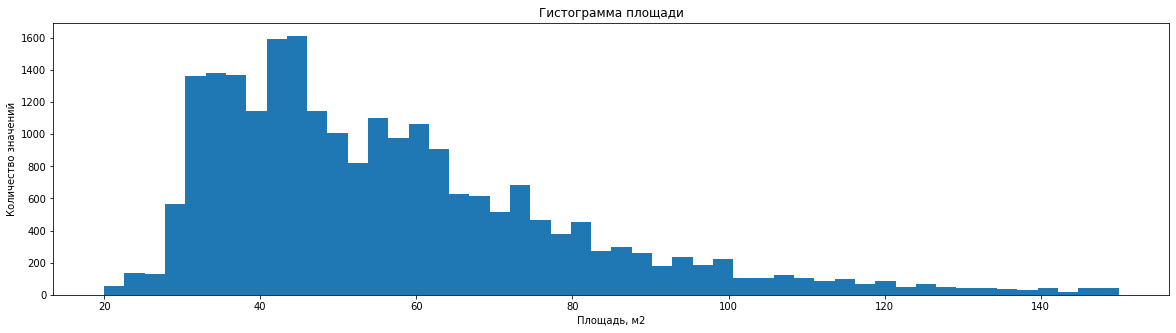

In [452]:
data_hist(data, 0.95)

In [453]:
def data_boxplot(data, column):
   
    target = ['total_area']
    
    for i in target:
        fig, ax = plt.subplots(figsize=(15, 3))
        data[i].plot(y=column, kind='box', grid=True, subplots=True, color='g')
        plt.ylim(20, 150)
        ax.set_title("Гистограмма площади квартир")
        ax.set_xlabel('Количество значений')
        ax.set_ylabel('Площадь, м2')

    return plt.show()

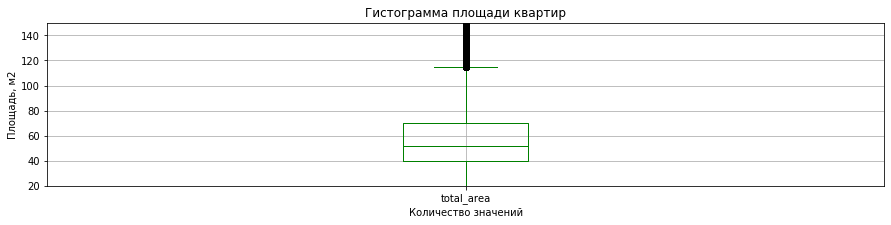

In [454]:
data_boxplot(data, 'Площадь, м2')

И так, чаще всего покупают квартиры от 35 до 65 м2. Хотя, интересно, что квартиры в 100 кв. м. покупают такие чаще чем крошечные, возможно тут дело в количестве предложений, невозможно купить то чего нет. 

Число комнат.

In [455]:
len(data.query('rooms > 6'))


90

In [456]:
len(data.query('rooms < 6'))

23387

Text(0, 0.5, 'Количество значений')

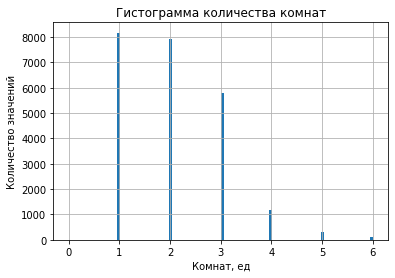

In [457]:
ax = data["rooms"].hist(bins=100, range=(0, 6))
ax.set_title("Гистограмма количества комнат")
ax.set_xlabel("Комнат, ед")
ax.set_ylabel("Количество значений")

Высота потолков.

Text(0, 0.5, 'Количество значений')

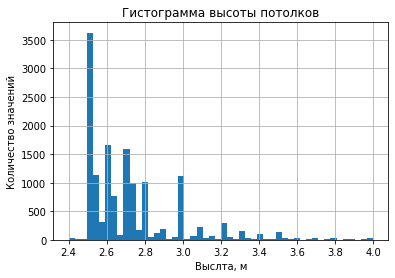

In [458]:
ax = data["ceiling_height"].hist(bins=50, range=(2.4, 4))
ax.set_title("Гистограмма высоты потолков")
ax.set_xlabel("Выслта, м")
ax.set_ylabel("Количество значений")

Цена квартиры.

In [459]:
data['last_price'].sort_values()

8793         12190.0
14911       430000.0
17456       430000.0
16274       440000.0
16219       450000.0
            ...     
15651    300000000.0
1436     330000000.0
14706    401300000.0
19540    420000000.0
12971    763000000.0
Name: last_price, Length: 23582, dtype: float64

In [460]:
data['last_price'].describe()

count    2.358200e+04
mean     6.544685e+06
std      1.089615e+07
min      1.219000e+04
25%      3.434250e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

In [461]:
len(data.query('last_price < 1000000'))

225

In [462]:
len(data.query('last_price > 7000000'))

5414

Основной диапазон продаж между 1 и 7 миллионами.

Text(0, 0.5, 'Количество значений')

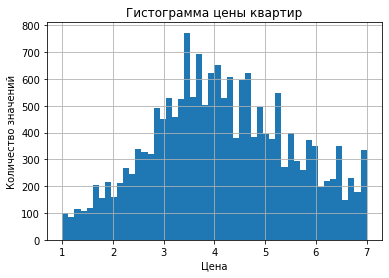

In [463]:
ax = (data["last_price"]/1000000).hist(bins=50, range=(1, 7)) #удобнее без лишних нулей
ax.set_title("Гистограмма цены квартир")
ax.set_xlabel("Цена")
ax.set_ylabel("Количество значений")

Площадь - основной диапазон между 35 и 65 кв. м., пик где то около 50-55 кв. м., 
Комнаты - больше всего 1-3 комнатные квартиры, потом резкий спад.
Цена - интересный скачок на 7 миллионах,  с 2,5 до, примерно, 5,5 миллионов самое кучное распределение
В целом, данные по всем трем параметрам логичны и, скорее всего, взаимосвязаны

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:<a id="шаг_4"></a>

Изучим время продажи квартир.

In [464]:
data['days_exposition'].describe()

count    20402.000000
mean       181.065337
std        219.980329
min          1.000000
25%         45.000000
50%         96.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

По данным из интернета, в среднем квартира продается от 1 до 3х месяцев, что точно подтверждается нашей выборкой и гистограммой

In [465]:
def days_category(row):
    days_exposition = row['days_exposition']
    if days_exposition <= 30:
        return 'быстро'
    if days_exposition >= 31 < 90:        
        return 'средне'
    return 'долго'
    
data['days_category'] = data.apply(days_category, axis=1)

data['days_category'].value_counts()

средне    16689
быстро     3713
долго      3180
Name: days_category, dtype: int64

Text(0, 0.5, 'Количество значений')

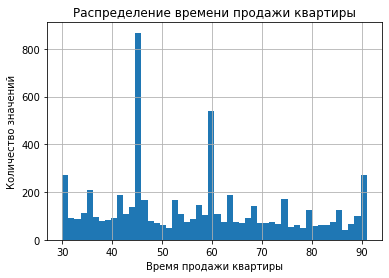

In [466]:
ax = data["days_exposition"].hist(bins=50, range=(30, 91))
ax.set_title("Распределение времени продажи квартиры")
ax.set_xlabel("Время продажи квартиры")
ax.set_ylabel("Количество значений")


Очень плавное распределение с пиками на 45 и 60 дней.

In [467]:
data["days_exposition"].median()

96.0

In [468]:
data["days_exposition"].mean()

181.06533673169298

По ходу анализа мы уже посмотрели на выбивающиеся значения, соберем их и отбросим для получения более реальной статистики

In [469]:
data['total_area'].describe()

count    23582.000000
mean        60.376985
std         35.497202
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

In [470]:
len(data.query('rooms > 5'))

195

Общая прощадь - отсекаем площадь более 150 кв м и менее 20кв м

In [471]:
data_good = data[(data['total_area'] <= 150) & (data['total_area'] >= 20)]

Количество комнат - отсекаем данные по жилью более 5-и комнат, это всего 195 строк.

In [472]:
data_good = data_good[data_good['rooms'] <= 5]

Я помню что в самом начале удивилась однушке по странной цене. Поищем осталась ли она после всех изменений

In [473]:
data_good.loc[(data_good['rooms'] == 1) & (data['last_price'] > 20000000)]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,new_locality_name,day_of_week,month,year,living_total_ratio,price_meter,floor_category,living_total,kitchen_total,days_category
4859,16,28000000.0,33.00,2019-04-29,1,3.50,5.0,15.982906,2,False,False,False,9.0,0.0,Санкт-Петербург,23.447,1.376,3.0,0.344,3.0,0.119,NaN,Санкт-Петербург,Monday,April,2019,NaN,848485.0,другой,48.433048,27.272727,долго
5286,12,23417400.0,75.50,2017-10-13,1,NaN,8.0,36.566952,4,False,False,False,9.0,0.0,Санкт-Петербург,32.440,5.297,0.0,0.000,2.0,0.198,111.0,Санкт-Петербург,Friday,October,2017,NaN,310164.0,другой,48.433048,11.920530,средне
8261,20,36000000.0,123.20,2018-01-14,1,3.00,14.0,0.253247,7,False,False,False,58.4,1.0,Санкт-Петербург,28.098,6.800,2.0,0.084,3.0,0.234,61.0,Санкт-Петербург,Sunday,January,2018,0.253247,292208.0,другой,0.205557,47.402597,средне
8322,20,39900000.0,55.30,2017-10-26,1,3.05,6.0,0.632911,4,False,False,False,8.0,4.0,Санкт-Петербург,25.685,2.136,1.0,0.072,3.0,0.202,NaN,Санкт-Петербург,Thursday,October,2017,0.632911,721519.0,другой,1.144505,14.466546,долго
14210,24,43511000.0,122.08,2017-08-17,1,NaN,7.0,0.288336,1,False,False,False,26.0,0.0,Санкт-Петербург,32.863,5.955,2.0,0.230,3.0,0.215,5.0,Санкт-Петербург,Thursday,August,2017,0.288336,356414.0,первый,0.236186,21.297510,быстро
15883,2,36000000.0,80.00,2018-11-21,1,3.40,7.0,0.412500,6,False,False,False,22.0,0.0,Санкт-Петербург,33.024,6.116,2.0,0.051,3.0,0.296,27.0,Санкт-Петербург,Wednesday,November,2018,0.412500,450000.0,другой,0.515625,27.500000,быстро
17172,14,28000000.0,33.00,2019-04-30,1,3.50,5.0,15.982906,2,False,False,False,9.0,0.0,Санкт-Петербург,23.403,1.462,3.0,0.342,3.0,0.027,NaN,Санкт-Петербург,Tuesday,April,2019,NaN,848485.0,другой,48.433048,27.272727,долго
18321,1,21280000.0,76.00,2019-04-01,1,3.00,11.0,0.493421,8,False,False,False,11.6,0.0,Санкт-Петербург,28.282,6.941,2.0,0.365,3.0,0.215,NaN,Санкт-Петербург,Monday,April,2019,0.493421,280000.0,другой,0.649238,15.263158,долго
21238,1,24412900.0,38.12,2018-06-27,1,NaN,10.0,0.441501,4,False,False,False,10.7,1.0,Всеволожск,0.000,0.000,0.0,0.000,0.0,0.000,44.0,Всеволожск,Wednesday,June,2018,0.441501,640422.0,другой,1.158186,28.069255,средне
22898,1,21821800.0,76.30,2019-04-01,1,3.00,11.0,0.496723,9,False,False,False,11.6,0.0,Санкт-Петербург,28.282,6.941,2.0,0.365,3.0,0.215,NaN,Санкт-Петербург,Monday,April,2019,0.496723,286000.0,другой,0.651014,15.203145,долго


Вот как. Оказывается есть однушки стоимостью 20 миллионов. И даже за 36 миллионов: 123 кв. м. с кухней 58 кв м. Это явная аномалия, квартира или по индивидуальной планировке или студия или банальные ошибки в данных. Интересно было бы разобрать. Но, сейчас нас это не интересует. Они отсеятся вместе с аномальной ценой, т.к. мы уже выяснили, что средняя максимальнаяч цена около 7 миллионов, все таки расширим диапазон до 15 миллионов  т.к. в диапазоне от 7-и до 15 миллинов более 2 000 строк данных, это уже достаточно много.

In [474]:
data_good = data_good[data_good['last_price'] <= 15000000]

In [475]:
data_good.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,year,living_total_ratio,price_meter,living_total,kitchen_total
count,22249.000000,2.224900e+04,22249.000000,22249.000000,13571.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,22249.000000,19451.000000,22249.000000,20516.000000,22249.000000,22249.000000,22249.000000
mean,9.752708,5.134044e+06,54.776502,1.974291,2.744488,10.728302,2.980163,5.898108,9.734671,0.594139,21.803343,11.114885,0.432019,0.158020,0.548204,0.193844,175.971724,2017.383837,0.563968,93631.263562,5.425294,18.877226
std,5.584512,2.667042e+06,20.414449,0.908065,1.278799,6.647804,9.248936,4.901172,4.089101,0.951708,16.734055,9.757561,0.715053,0.298447,0.847150,0.305111,214.684126,1.025958,0.103886,31264.484669,14.834409,7.302217
min,0.000000,1.219000e+04,20.000000,1.000000,1.000000,1.000000,0.038462,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2014.000000,0.038462,112.000000,0.073964,0.000000
25%,6.000000,3.380000e+06,39.500000,1.000000,2.500000,5.000000,0.500000,2.000000,7.000000,0.000000,7.659000,1.325000,0.000000,0.000000,0.000000,0.000000,44.000000,2017.000000,0.494894,75279.000000,0.878099,13.548387
50%,9.000000,4.500000e+06,50.100000,2.000000,2.630000,9.000000,0.579176,4.000000,9.000000,0.000000,21.102000,11.615000,0.000000,0.000000,0.000000,0.000000,93.000000,2017.000000,0.567108,93478.000000,1.145625,17.483444
75%,14.000000,6.290000e+06,65.500000,3.000000,2.770000,16.000000,0.657111,8.000000,11.000000,1.000000,34.631000,15.457000,1.000000,0.267000,1.000000,0.373000,223.000000,2018.000000,0.636364,111011.000000,1.470588,23.391813
max,50.000000,1.500000e+07,150.000000,5.000000,100.000000,60.000000,97.641834,33.000000,64.000000,5.000000,84.869000,65.968000,3.000000,3.190000,3.000000,1.344000,1580.000000,2019.000000,0.975754,600000.000000,65.974212,78.787879


 ## Как некие факторы влияют на стоимость квартир.

Площадь квартиры

(1000000, 10500000)

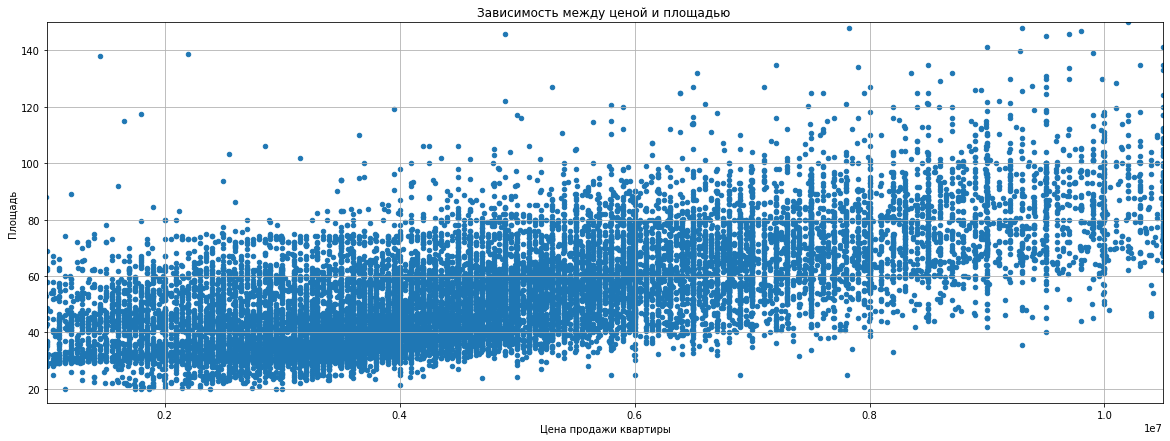

In [476]:
ax = data_good.plot(x='last_price', y='total_area', kind="scatter", style='o', grid=True, figsize=(20,7)) 
ax.set_title("Зависимость между ценой и площадью ")
ax.set_xlabel("Цена продажи квартиры")
ax.set_ylabel("Площадь")
plt.ylim(15, 150)
plt.xlim(1000000, 10500000)


Без сюрпризов, чем больше площадь, тем дороже. Но, видно что это не самое значимое, очень большой диапозон цен в узком луче площадей. Площадь квартиры явно важный, но не единственный фактор формирования цены.

Зависимость от количества комнат

(0, 6)

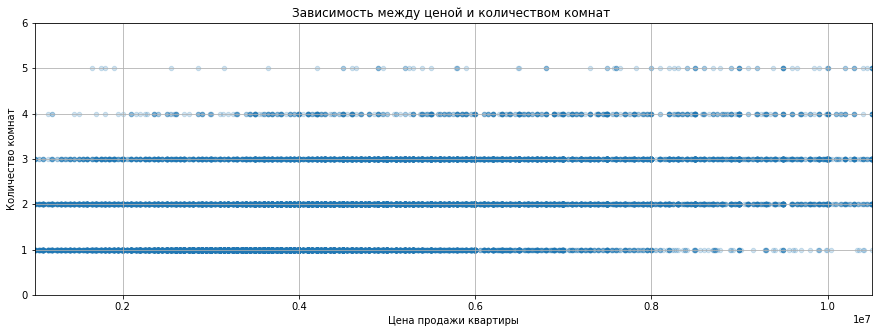

In [477]:
ax = data_good.plot(x='last_price', y='rooms', kind="scatter", style='*', alpha=.2, grid=True, figsize=(15,5)) 
ax.set_title("Зависимость между ценой и количеством комнат ")
ax.set_xlabel("Цена продажи квартиры")
ax.set_ylabel("Количество комнат")
plt.xlim(1000000, 10500000)
plt.ylim(0, 6)

Очевидно что 1 комнатные дешевле остальных, но вот цена между 2-х и 3-х комнатными сильно смазана, в некотором диапазоне даже сливается. т.е., тоже, не самый важный параметр.

Text(0.5, 1.0, 'Зависимость между ценой и количеством комнат ')

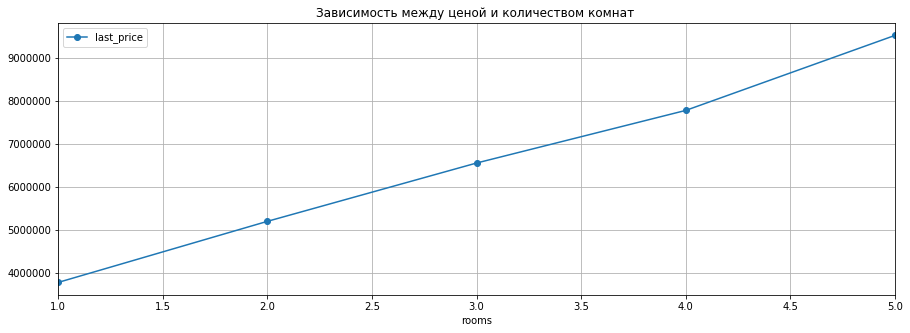

In [478]:
(
    data_good
    .pivot_table(index = 'rooms', values = 'last_price')
    .plot(style = '-o', grid=True, figsize = (15,5))
    .set_title("Зависимость между ценой и количеством комнат ")
    
)

Text(0.5, 1.0, 'Зависимость между прощадью и количеством комнат ')

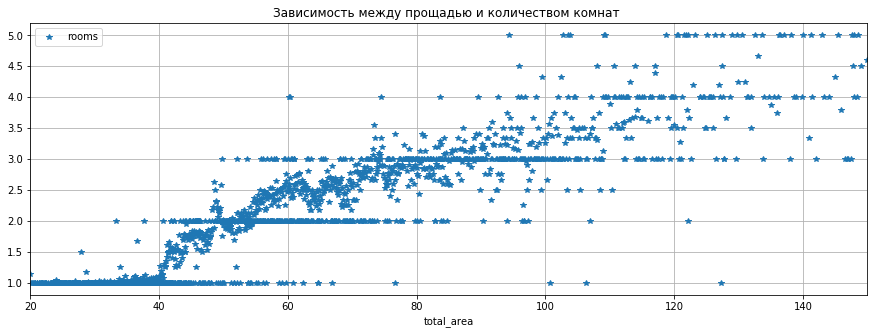

In [479]:
(
    data_good
    .pivot_table(index = 'total_area', values = 'rooms')
    .plot(style = '*', grid=True, figsize = (15,5))
    .set_title("Зависимость между прощадью и количеством комнат ")
)

Собственно, показывает предыдущия заключения, площадь квартир и количество комнат, в некотором диапазоне  смазываются. Отсюда и такая кривая по ценам.  
Как важен этаж расположения квартиры для формирования цены?

Text(0.5, 1.0, 'Зависимость между ценой и этажом ')

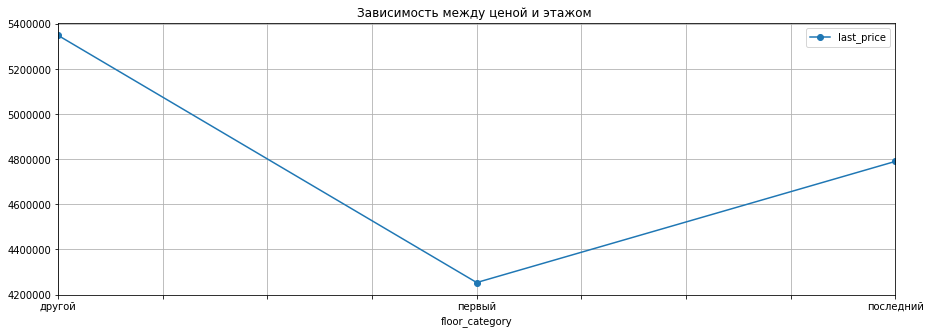

In [480]:
(
    data_good
    .pivot_table(index = 'floor_category', values = 'last_price')
    .plot(style = '-o', grid=True, figsize = (15,5))
    .set_title("Зависимость между ценой и этажом ")
)

Первый и последние этажи явно не в почете.  
Теперь посмотрим как влияет отдаленность от центра города.

Text(0.5, 1.0, 'Зависимость между ценой и отдаленностью от центра ')

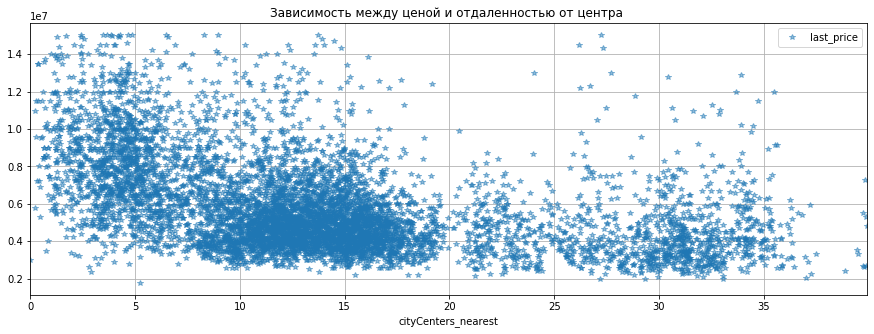

In [481]:
(
    data_good
    .query('cityCenters_nearest <40')
    .pivot_table(index = 'cityCenters_nearest', values = 'last_price')
    .plot(style = '*', grid=True, figsize = (15,5), alpha=0.5)
    .set_title("Зависимость между ценой и отдаленностью от центра ")
)

Text(0.5, 1.0, 'Зависимость между ценой и отдаленностью от парков ')

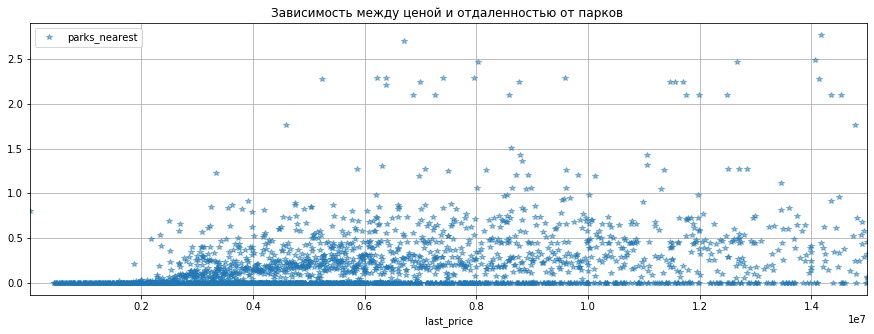

In [482]:
(
    data_good
    .pivot_table(index = 'last_price', values = 'parks_nearest')
    .plot(style = '*', grid=True, figsize = (15,5), alpha=0.5)
    .set_title("Зависимость между ценой и отдаленностью от парков ")
)

Да, зависимость явная. Все хотят жить поближе к центру и рядышком с парком.
Влияют ли день недели, месяц и год на цену квартиры?

Text(0.5, 1.0, 'Зависимость между ценой и днем недели ')

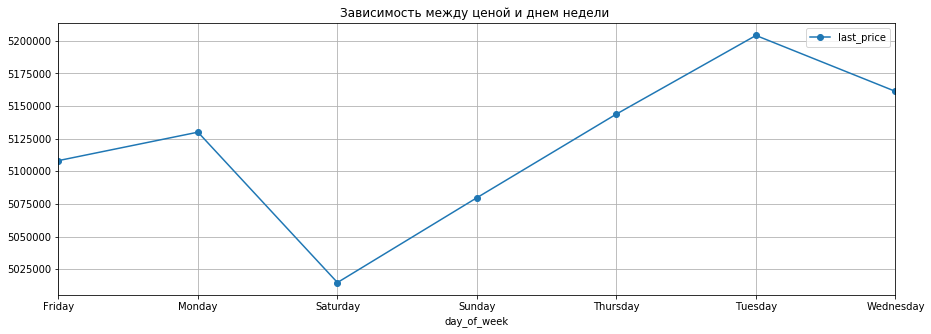

In [483]:
(
    data_good
    .pivot_table(index = 'day_of_week', values = 'last_price')
    .plot(style = '-o', grid=True, figsize = (15,5))
    .set_title("Зависимость между ценой и днем недели ")
)

День недели явно не влияет на цену. Может быть есть сезонность? Посмотрим по месяцам.

Text(0.5, 1.0, 'Зависимость между ценой и месяцем публикации ')

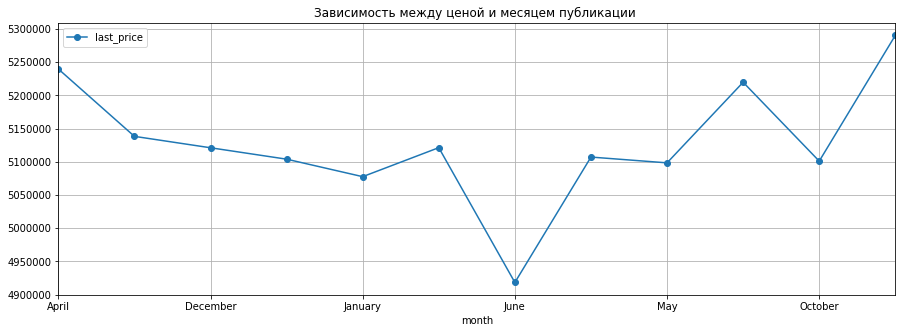

In [484]:
(
    data_good
    .pivot_table(index = 'month', values = 'last_price')
    .plot(style = '-o', grid=True, figsize = (15,5))
    .set_title("Зависимость между ценой и месяцем публикации ")
)

Как изменялась цена на квартиры по годам.

Text(0.5, 1.0, 'Зависимость между ценой и годом публикации ')

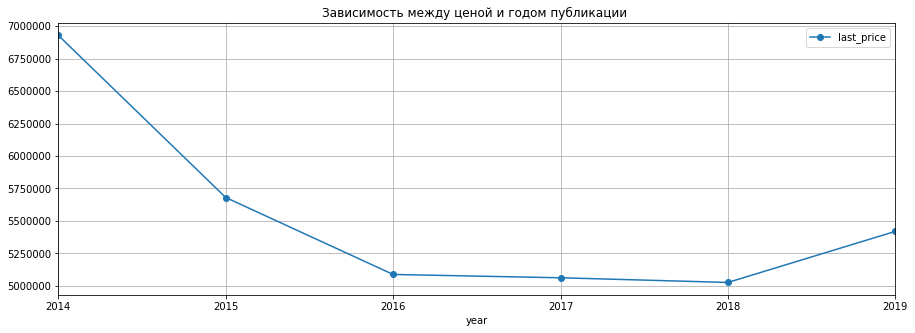

In [485]:
(
    data_good
    .pivot_table(index = 'year', values = 'last_price')
    .plot(style = '-o', grid=True, figsize = (15,5))
    .set_title("Зависимость между ценой и годом публикации ")
)

Очень сомнительная кривая, скорее всего дело в выборке данных - 2014г. всего 105 записей, если цены там указаны в одном диапазоне, а в 1051 записи 2015 года большой разброс цен, то и получатся  такие странные показатели.

Отберем 10 населенных пунктов с самым большим количеством объявлений

In [517]:
top_locality = data_good['new_locality_name'].value_counts().sort_values(ascending=False).head(10)

In [518]:
top_locality.head(10)


Санкт-Петербург    14415
Мурино               583
Кудрово              459
Шушары               439
Всеволожск           396
Пушкин               349
Колпино              336
Парголово            323
Гатчина              307
Выборг               235
Name: new_locality_name, dtype: int64

In [519]:
data_good.query('new_locality_name in @top_locality.index').pivot_table(index='locality_name', values='price_meter').sort_values(by='price_meter',ascending=False)

,price_meter
locality_name,
Санкт-Петербург,107355.877419
Пушкин,101233.699140
Кудрово,100253.046243
Мурино,92722.705882
деревня Кудрово,92296.905594
поселок Парголово,90348.972136
поселок Мурино,85503.695811
поселок Шушары,78655.608200
Колпино,75356.223214


Самая высокая цена за кв метр в Санкт-Петербурге и самая низкая - в Выборге. Почти догоняет СПб, город Пушкин, оно и понятно: Пу́шкин — город в составе Пушкинского района города федерального значения Санкт-Петербурга и его внутригородское муниципальное образование, в 1936 году был передан в административное подчинение Ленинграда. Крупный туристический, научный, учебный и военно-промышленный центр. 

Изучим цены в Санкт-Петербурге

In [520]:
data_spb = data_good.query('new_locality_name == "Санкт-Петербург"')

(0, 20)

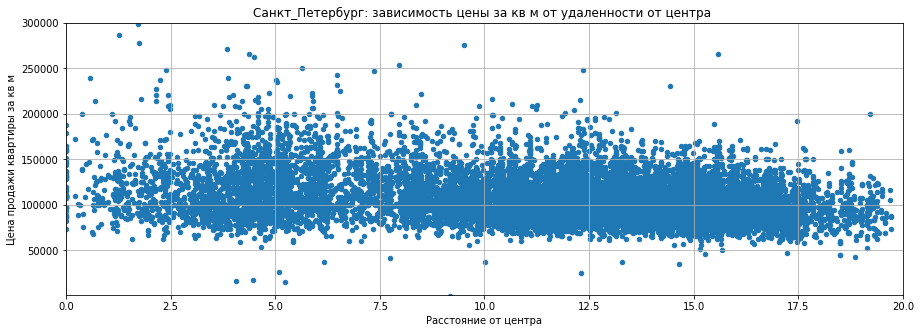

In [521]:
ax = data_spb.plot(x='cityCenters_nearest', y='price_meter', kind="scatter", style='*', grid=True, figsize=(15,5)) 
ax.set_title("Санкт_Петербург: зависимость цены за кв м от удаленности от центра ")
ax.set_xlabel("Расстояние от центра")
ax.set_ylabel("Цена продажи квартиры за кв м")
plt.ylim(1000, 300000)
plt.xlim(0, 20)

In [491]:
data_spb['cityCenters_nearest'].corr(data_spb['price_meter'])

-0.30436031466485497

Даже чисто зрительно видно что цена имеет пик в диапазоне от 2,5 до 7,5 км, а потом выравнивается.  
Сделаем границу удоленности от центра в 10 км и проанализируем данные.

In [492]:
data_spb_center = data_spb[(data_spb['cityCenters_nearest'] <= 10) & (data_spb['cityCenters_nearest'] > 0)]

In [493]:
data_spb_center['price_meter'].describe()

count      4044.000000
mean     117839.341988
std       31784.256536
min         112.000000
25%       95921.500000
50%      112358.500000
75%      134810.750000
max      600000.000000
Name: price_meter, dtype: float64

(0, 600000)

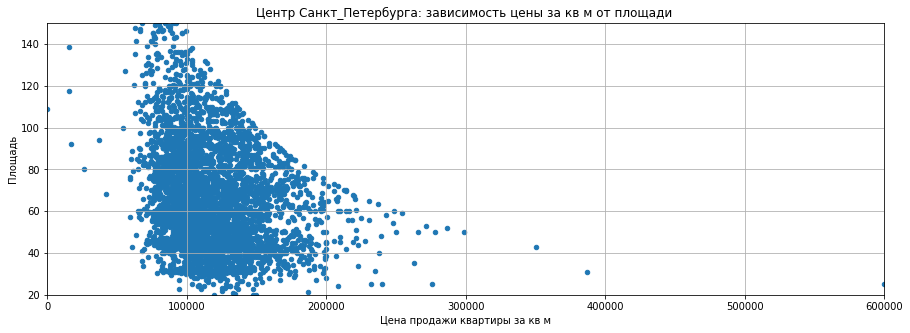

In [494]:
ax = data_spb_center.plot(x='price_meter', y='total_area', kind="scatter", style='*', grid=True, figsize=(15,5)) 
ax.set_title("Центр Санкт_Петербурга: зависимость цены за кв м от площади ")
ax.set_xlabel("Цена продажи квартиры за кв м")
ax.set_ylabel("Площадь")
plt.ylim(20, 150)
plt.xlim(0, 600000)

(0, 400000)

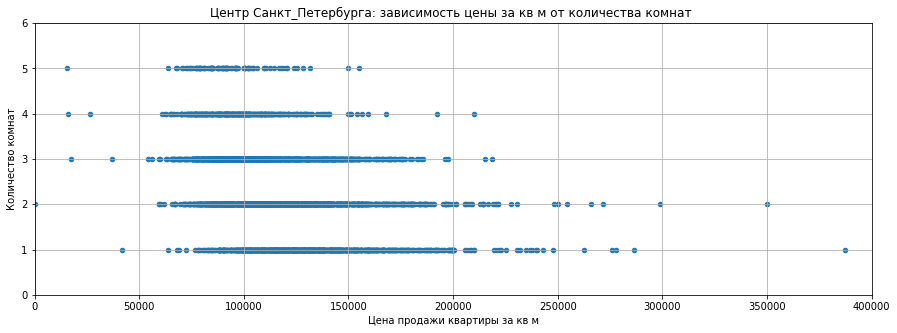

In [495]:
ax = data_spb_center.plot(x='price_meter', y='rooms', kind="scatter", style='*', grid=True, figsize=(15,5)) 
ax.set_title("Центр Санкт_Петербурга: зависимость цены за кв м от количества комнат ")
ax.set_xlabel("Цена продажи квартиры за кв м")
ax.set_ylabel("Количество комнат")
plt.ylim(0, 6)
plt.xlim(0, 400000)

Text(0.5, 1.0, 'Зависимость между ценой и этажом ')

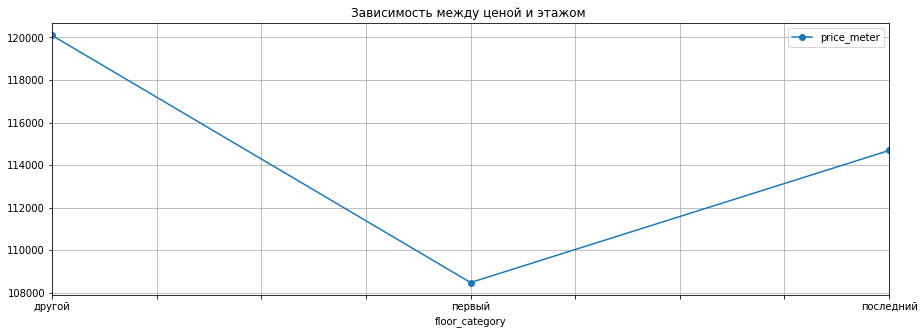

In [496]:
(
    data_spb_center
    .pivot_table(index = 'floor_category', values = 'price_meter')
    .plot(style = '-o', grid=True, figsize = (15,5))
    .set_title("Зависимость между ценой и этажом ")
)

(0, 400000)

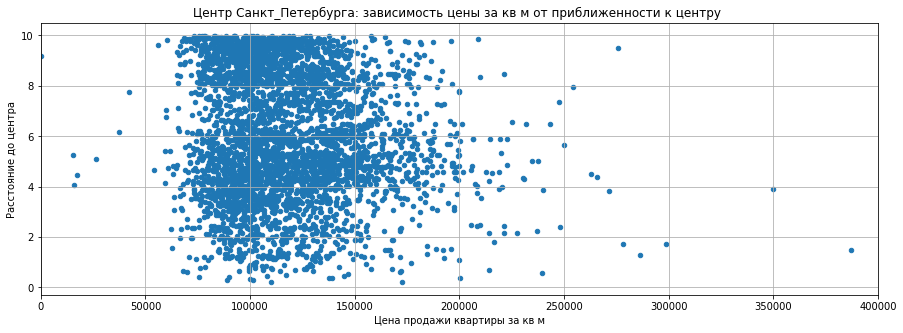

In [497]:
ax = data_spb_center.plot(x='price_meter', y='cityCenters_nearest', kind="scatter", style='*', grid=True, figsize=(15,5)) 
ax.set_title("Центр Санкт_Петербурга: зависимость цены за кв м от приближенности к центру ")
ax.set_xlabel("Цена продажи квартиры за кв м")
ax.set_ylabel("Расстояние до центра")
plt.xlim(0, 400000)


(0, 400000)

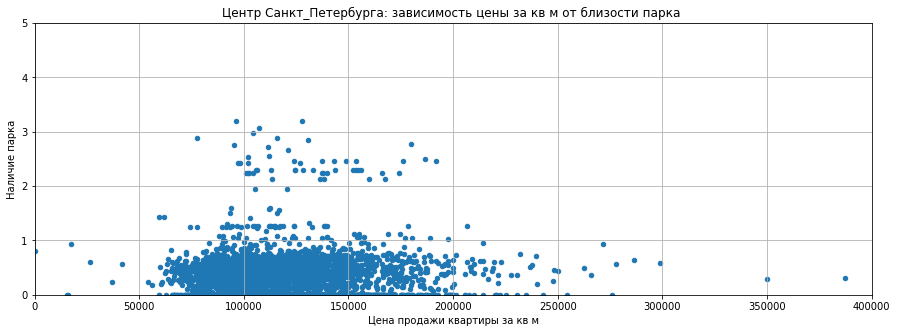

In [498]:
ax = data_spb_center.plot(x='price_meter', y='parks_nearest', kind="scatter", style='*', grid=True, figsize=(15,5)) 
ax.set_title("Центр Санкт_Петербурга: зависимость цены за кв м от близости парка ")
ax.set_xlabel("Цена продажи квартиры за кв м")
ax.set_ylabel("Наличие парка")
plt.ylim(0, 5)
plt.xlim(0, 400000)

(0, 400000)

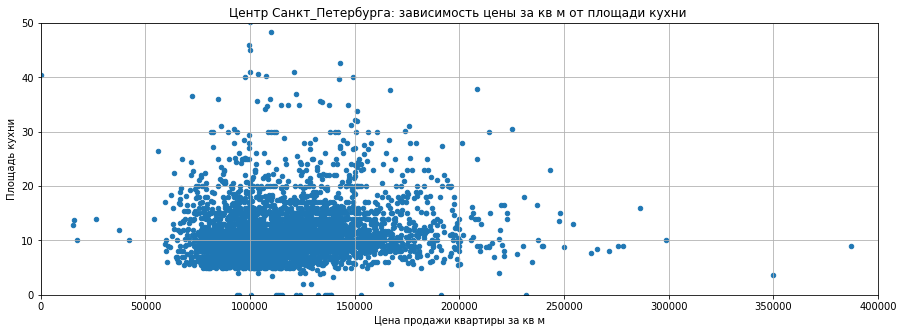

In [522]:
ax = data_spb_center.plot(x='price_meter', y='kitchen_area', kind="scatter", style='*', grid=True, figsize=(15,5)) 
ax.set_title("Центр Санкт_Петербурга: зависимость цены за кв м от площади кухни ")
ax.set_xlabel("Цена продажи квартиры за кв м")
ax.set_ylabel("Площадь кухни")
plt.ylim(0, 50)
plt.xlim(0, 400000)

Совершенно понятно что цена за квадратный метр площади имеет небольшой разброс, который сохраняется по всем параметрам, видимо этот разброс зависит от каких-то неуказанных в нашей выборке параметров, будь то год строительства дома, ремонт и пр.

Text(0, 0.5, 'Количество значений')

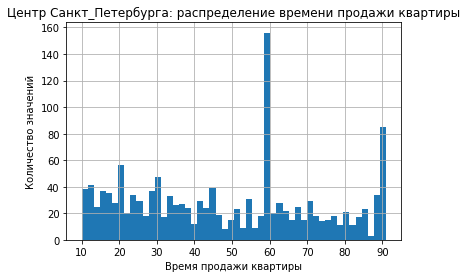

In [500]:
ax = data_spb_center["days_exposition"].hist(bins=50, range=(10, 91))
ax.set_title("Центр Санкт_Петербурга: распределение времени продажи квартиры")
ax.set_xlabel("Время продажи квартиры")
ax.set_ylabel("Количество значений")

И вот время продажи квартир отличается, большее количество квартир в центре продаются около 2-х месяцев.

## Оценим разницу между средней стоимостью квартир в центре и в отдалении от центра.

In [501]:
data_spb_nocenter = data_spb[(data_spb['cityCenters_nearest'] > 10)]

In [502]:
data_spb_nocenter['price_meter'].describe()

count     10327.000000
mean     103187.474388
std       21186.498838
min       24440.000000
25%       88636.000000
50%      100223.000000
75%      114992.500000
max      312240.000000
Name: price_meter, dtype: float64

In [503]:
data_spb_center['price_meter'].describe()

count      4044.000000
mean     117839.341988
std       31784.256536
min         112.000000
25%       95921.500000
50%      112358.500000
75%      134810.750000
max      600000.000000
Name: price_meter, dtype: float64

In [504]:
def data_spb_center_hist(data_spb_center, column):
      
    target = ['total_area']
    
    
    for i in target:
        range_max = data_spb_center[i].quantile(column)
        
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title("Центр Санкт_Петербурга: гистограмма площади")
        ax.set_xlabel("Площадь, м2")
        ax.hist(data_spb_center[i], bins=50, histtype='bar', range=(20, 150))
        ax.set_ylabel('Количество значений')

    return plt.show()

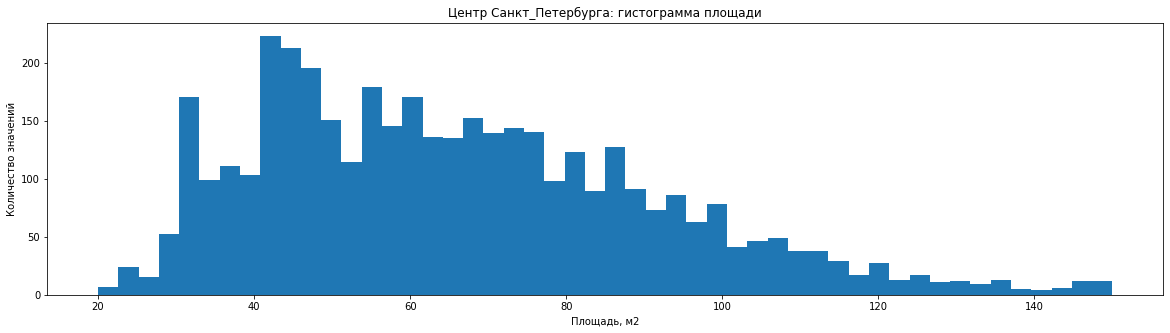

In [505]:
data_spb_center_hist(data_spb_center, 0.95)

In [506]:
def data_spb_nocenter_hist(data_spb_center, column):
      
    target = ['total_area']
    
    
    for i in target:
        range_max = data_spb_nocenter[i].quantile(column)
        
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title("Гистограмма площади")
        ax.set_xlabel("Площадь, м2")
        ax.hist(data_spb_nocenter[i], bins=50, histtype='bar', range=(20, 150))
        ax.set_ylabel('Количество значений')

    return plt.show()

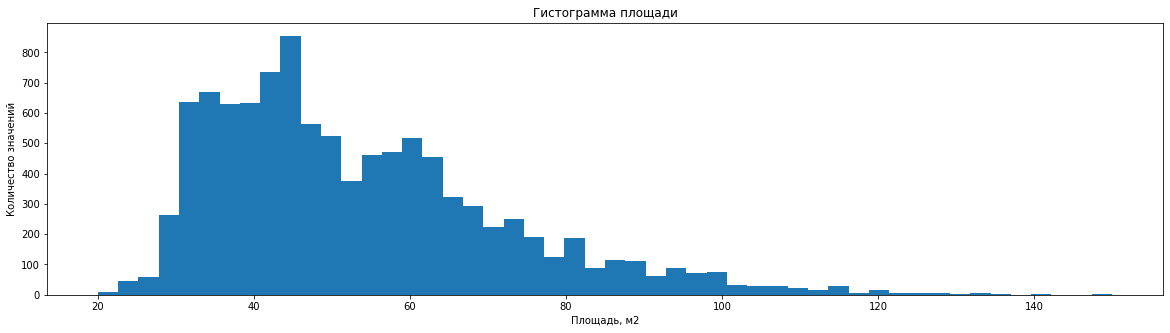

In [507]:
data_spb_nocenter_hist(data_spb_nocenter, 0.95)

In [508]:
def data_spb_center_hist(data_spb_center, column):
      
    target = ['rooms']
    
    
    for i in target:
        range_max = data_spb_center[i].quantile(column)
        
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title("Центр Санкт_Петербурга: гистограмма количества комнат")
        ax.set_xlabel("Количество комнат")
        ax.hist(data_spb_center[i], bins=50, histtype='bar', range=(0, 6))
        ax.set_ylabel('Количество значений')

    return plt.show()

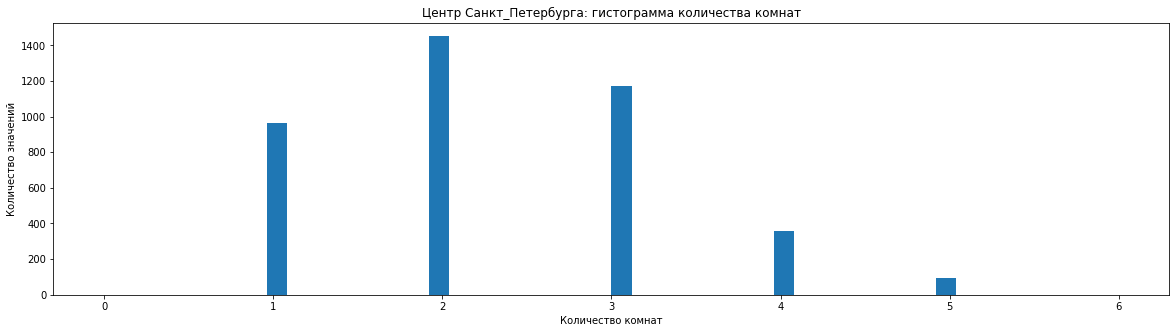

In [509]:
data_spb_center_hist(data_spb_center, 0.95)

In [510]:
def data_spb_nocenter_hist(data_spb_center, column):
      
    target = ['rooms']
    
    
    for i in target:
        range_max = data_spb_nocenter[i].quantile(column)
        
        fig, ax = plt.subplots(figsize=(20, 5))
        ax.set_title("Гистограмма количества комнат")
        ax.set_xlabel("Количество комнат")
        ax.hist(data_spb_nocenter[i], bins=50, histtype='bar', range=(0, 6))
        ax.set_ylabel('Количество значений')

    return plt.show()

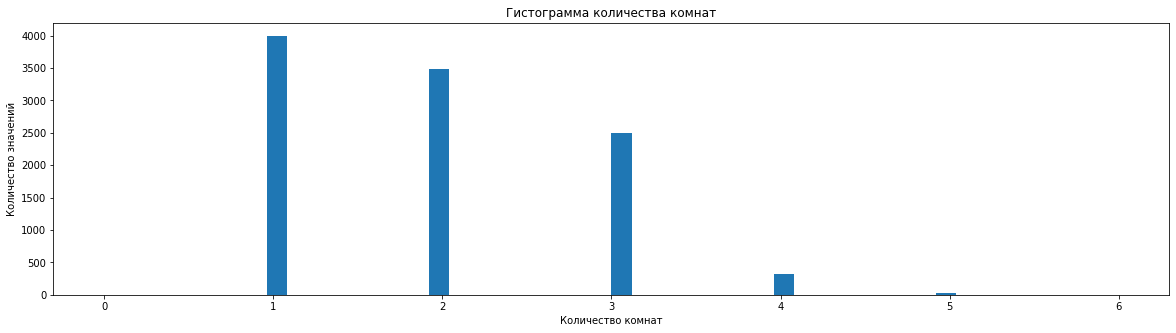

In [511]:
data_spb_nocenter_hist(data_spb_nocenter, 0.95)

Явно видна разница в площади продаваемых квартир, она объясняет такой разброс в ценах в центре СПб: если в центре площадь квартир варьируется от 35 до 100 кв м, то в отдалении от центра основная масса квартир в диавпазоне 35-65 кв метров.  
В количестве комнат тоже видна разница: в центре преобладают продажи 1-3 комнатные, в отдалении от центре преобладают продажи однушек и двушек.

### Шаг 5. Общий вывод<a id="шаг_5"></a>

 Был проведен анализ объявлений о продаже квартир по г.Санкт-Петербургу и Ленинградской области.  
 Были выявлены и исправлены ошибки в записях, заполнены пропуски и стандартизированны данные в названиях населенных пунктов.   
 При обработке данных были выявлены и удалены "плохие данные", аномалии, которые могли бы исказить статистику.  
 В ходе анализа были рассмотрены сроки продажи квартир  - выявлены средние сроки продажи, это 60 дней по г.Санкт-Петербургу и 30-45 дней в области. Но есть квартиры которые продаются и по 6 месяцев- при наличии достаточных данных можно будет сделать анализ именно по этому параметру.  
 Совершенно точно на цену квартир не влияют ни день недели публикации объявления ни сезон.  
 Не представляется возможным проследить изменение цены с разбивкой по годам т.к. выборка данных по годам предоставлена не корректно и дает основание пологать что график не показыввает реальное положение дел.  
  Далее, были выявлены факторы влияющие на цену квартиры. Выявила как одни и теже факторы влияют на цену в центре СПб и в отдалении. Из стандартных параметров на цену любой квартиры влияет этаж - квартиры на первом и последних этажах существенно дешевле остальных квартир, при чем, на превом этаже квартиры дешевле чем на последнем.   
При анализе квартир расположеных в центре и в отдалении от центра, также по диапазону площадей и количеству комнат, так в центре предпочитаю 2-3 комнатные квартиры, а в отдаленности от центра - 1 комнатные. Соответсвенно диапазон площадей в отдалении от центра гораздо уже чем в центре.  
 Средняя цена квартиры за квадратный метр при всем этом не сильно отличается, но минимальная и максимальная цены, на жилище в центре имеют очень большой разброс, что, в свою очередь обосновано разбросом площадей продаваемых квартир.
В целом, можно сказать что люди предпочитают покупать квартиры средней площади, не на первом и последнем этажах и поближе от центра и парков. Цена растет в зависимости от этих параметров.

### Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод info())
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  посчитано и добавлено в таблицу: цена квадратного метра
- [x]  посчитано и добавлено в таблицу: день недели, месяц и год публикации объявления
- [x]  посчитано и добавлено в таблицу: этаж квартиры; варианты — первый, последний, другой
- [x]  посчитано и добавлено в таблицу: соотношение жилой и общей площади, а также отношение площади кухни к общей
- [x]  изучены следующие параметры: площадь, цена, число комнат, высота потолков
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите время продажи квартиры. Постройте гистограмму. Посчитайте среднее и медиану. Опишите, сколько обычно занимает продажа. Когда можно считать, что продажи прошли очень быстро, а когда необычно долго?"
- [x]  выполнено задание: "Уберите редкие и выбивающиеся значения. Опишите, какие особенности обнаружили."
- [x]  выполнено задание: "Какие факторы больше всего влияют на стоимость квартиры? Изучите, зависит ли цена от квадратного метра, числа комнат, этажа (первого или последнего), удалённости от центра. Также изучите зависимость от даты размещения: дня недели, месяца и года. "Выберите 10 населённых пунктов с наибольшим числом объявлений. Посчитайте среднюю цену квадратного метра в этих населённых пунктах. Выделите населённые пункты с самой высокой и низкой стоимостью жилья. Эти данные можно найти по имени в столбце '*locality_name'*. "
- [x]  выполнено задание: "Изучите предложения квартир: для каждой квартиры есть информация о расстоянии до центра. Выделите квартиры в Санкт-Петербурге (*'locality_name'*). Ваша задача — выяснить, какая область входит в центр. Создайте столбец с расстоянием до центра в километрах: округлите до целых значений. После этого посчитайте среднюю цену для каждого километра. Постройте график: он должен показывать, как цена зависит от удалённости от центра. Определите границу, где график сильно меняется — это и будет центральная зона. "
- [x]  выполнено задание: "Выделите сегмент квартир в центре. Проанализируйте эту территорию и изучите следующие параметры: площадь, цена, число комнат, высота потолков. Также выделите факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления). Сделайте выводы. Отличаются ли они от общих выводов по всему городу?"
- [x]  в каждом этапе есть выводы
- [x]  есть общий вывод